# Custom Deep Learning Model with a ResNet18 Backbone for CIFAR-10 Image Classification

In [ ]:
#1. Importing Libraries and Verifying Setup

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np

print("STEP 1: Importing and verifying libraries...")
print(f"- PyTorch version: {torch.__version__}")
print(f"- Torchvision version: {torchvision.__version__}")
print(f"- PyTorch Lightning version: {pl.__version__}")
print(f"- CUDA available: {torch.cuda.is_available()}")
print("✓ Libraries imported and verified!")

STEP 1: Importing and verifying libraries...
- PyTorch version: 2.5.1+cu124
- Torchvision version: 0.20.1+cu124
- PyTorch Lightning version: 2.5.1
- CUDA available: True
✓ Libraries imported and verified!


In [ ]:
#2. Building the Model - ResNet18 Backbone

In [3]:
print("\nSTEP 2: Defining model architecture...")
print("- Loading ResNet18 backbone...")
try:
    backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    print("- Removing final layers...")
    backbone = nn.Sequential(*list(backbone.children())[:-2])
    test_input = torch.randn(1, 3, 224, 224)
    test_output = backbone(test_input)
    print(f"- Backbone output shape: {test_output.shape}")
except Exception as e:
    print(f"ERROR in backbone setup: {str(e)}")
    raise


STEP 2: Defining model architecture...
- Loading ResNet18 backbone...
- Removing final layers...
- Backbone output shape: torch.Size([1, 512, 7, 7])


In [ ]:
#3. Defining the Custom Head

In [4]:
print("- Defining custom head...")
class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features, num_classes)
        print(f"- CustomHead initialized with {in_features} input features and {num_classes} output classes")
    
    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

- Defining custom head...


In [ ]:
#4. Combining into CustomModel

In [5]:
print("- Defining complete model...")
class CustomModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.head = CustomHead(512, num_classes)
        print(f"- CustomModel initialized with {num_classes} classes")
        
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

print("✓ Model architecture defined!")

- Defining complete model...
✓ Model architecture defined!


In [ ]:
#5. Preparing the CIFAR-10 Dataset

In [6]:
print("\nSTEP 3: Preparing CIFAR-10 dataset...")
print("- Defining transformations...")
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("- Loading CIFAR-10 dataset...")
try:
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    print(f"- Training samples: {len(train_dataset)}")
    print(f"- Test samples: {len(test_dataset)}")
except Exception as e:
    print(f"ERROR in dataset loading: {str(e)}")
    raise

print("- Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"- Class names: {class_names}")
print(f"- Number of classes: {len(class_names)}")
print("✓ Dataset preparation completed!")


STEP 3: Preparing CIFAR-10 dataset...
- Defining transformations...
- Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
- Training samples: 50000
- Test samples: 10000
- Creating data loaders...
- Class names: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
- Number of classes: 10
✓ Dataset preparation completed!


In [ ]:
#6. Setting Up the Training System

In [7]:
print("\nSTEP 4: Setting up training system...")
class CIFAR10TrainingSystem(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = CustomModel(backbone, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        print(f"- Training system initialized with {num_classes} classes")
        
    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        self.log('train_loss', loss)
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

print("✓ Training system setup completed!")


STEP 4: Setting up training system...
✓ Training system setup completed!


In [ ]:
#7. Training the Model

In [ ]:
print("\nSTEP 5: Starting training...")
num_classes = 10
print(f"- Number of classes set to: {num_classes}")
try:
    model_system = CIFAR10TrainingSystem(num_classes)
    print("- Model summary:")
    print(model_system)
    
    print("- Starting training for 5 epochs...")
    trainer = pl.Trainer(max_epochs=5, accelerator='auto', devices=1)
    trainer.fit(model_system, train_loader)
    print("- Training finished successfully!")
except Exception as e:
    print(f"ERROR during training: {str(e)}")
    raise

print("✓ Training completed!")

In [ ]:
#8. Saving and Testing the Model


STEP 6: Saving and testing model...
- Saving model weights...
✓ Model saved to 'cifar10_model.pth'
- Loading model for inference...
- CustomHead initialized with 512 input features and 10 output classes
- CustomModel initialized with 10 classes
✓ Model loaded successfully!

Testing on sample images...
- Testing indices: [0, 1000, 5000]
- Processing test image 0...
- Image shape: torch.Size([3, 224, 224]), Label: 3
- Model output shape: torch.Size([1, 10])
- Raw output: tensor([[ -3.8035,  -7.2910,  -1.8160,   6.5184,  -7.8245,   0.6855,  -4.0944,
          -8.3575,  -9.4045, -10.7708]])
- Predicted class index: 3


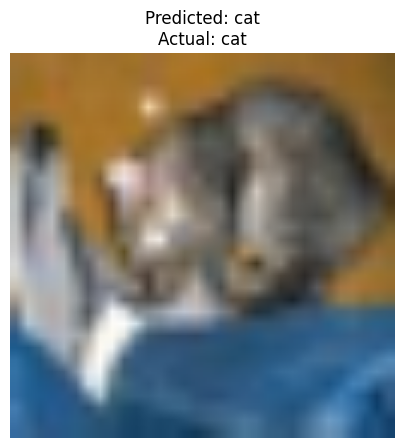

- Image 0: Predicted 'cat' (Actual: 'cat')
- Processing test image 1000...
- Image shape: torch.Size([3, 224, 224]), Label: 5
- Model output shape: torch.Size([1, 10])
- Raw output: tensor([[-9.3555, -9.1328, -4.6341,  1.3674, -5.8758,  5.9026,  1.3959, -5.9802,
         -8.2829, -7.8840]])
- Predicted class index: 5


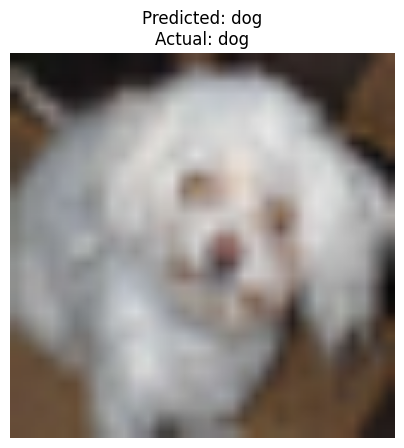

- Image 1000: Predicted 'dog' (Actual: 'dog')
- Processing test image 5000...
- Image shape: torch.Size([3, 224, 224]), Label: 7
- Model output shape: torch.Size([1, 10])
- Raw output: tensor([[-10.7836,  -6.4267, -13.4213,  -7.2330,  -6.5405,  -2.7434, -11.3278,
          15.4603, -14.1734,  -9.0385]])
- Predicted class index: 7


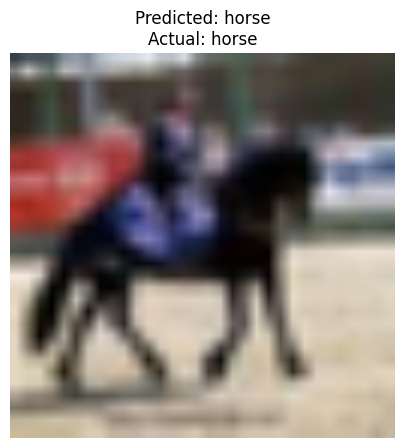

- Image 5000: Predicted 'horse' (Actual: 'horse')
✓ Testing completed!


In [8]:
print("\nSTEP 6: Saving and testing model...")
print("- Saving model weights...")
try:
    torch.save(model_system.model.state_dict(), 'cifar10_model.pth')
    print("✓ Model saved to 'cifar10_model.pth'")
except Exception as e:
    print(f"ERROR saving model: {str(e)}")
    raise

print("- Loading model for inference...")
try:
    loaded_model = CustomModel(backbone, num_classes)
    loaded_model.load_state_dict(torch.load('cifar10_model.pth', weights_only=True))
    loaded_model.eval()
    print("✓ Model loaded successfully!")
except Exception as e:
    print(f"ERROR loading model: {str(e)}")
    raise

print("\nTesting on sample images...")
def predict_and_show(idx):
    print(f"- Processing test image {idx}...")
    try:
        image, label = test_dataset[idx]
        print(f"- Image shape: {image.shape}, Label: {label}")
        with torch.no_grad():
            output = loaded_model(image.unsqueeze(0))
            print(f"- Model output shape: {output.shape}")
            print(f"- Raw output: {output}")
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()
            print(f"- Predicted class index: {predicted_class}")
        
        if not 0 <= predicted_class < len(class_names):
            raise ValueError(f"Predicted class {predicted_class} out of range (0-{len(class_names)-1})")
        if not 0 <= label < len(class_names):
            raise ValueError(f"Label {label} out of range (0-{len(class_names)-1})")
        
        plt.figure(figsize=(5, 5))
        img_to_show = image.permute(1, 2, 0) * 0.5 + 0.5
        plt.imshow(img_to_show)
        plt.title(f"Predicted: {class_names[predicted_class]}\nActual: {class_names[label]}")
        plt.axis('off')
        plt.show()
        print(f"- Image {idx}: Predicted '{class_names[predicted_class]}' (Actual: '{class_names[label]}')")
    except Exception as e:
        print(f"ERROR in predict_and_show for image {idx}: {str(e)}")
        raise

valid_indices = [0, min(1000, len(test_dataset)-1), min(5000, len(test_dataset)-1)]
print(f"- Testing indices: {valid_indices}")
for idx in valid_indices:
    predict_and_show(idx)

print("✓ Testing completed!")

In [ ]:
#Predicting a Custom Image


STEP 7: Predicting a custom image from current directory...
- Checking for image 'data/test/cat1.jpeg' in current directory...
- Image 'data/test/cat1.jpeg' found!
- Loading and preprocessing image...
- Preprocessed image shape: torch.Size([3, 224, 336])
- Making prediction...
- Model output shape: torch.Size([1, 10])
- Raw output: tensor([[ -4.2682,  -9.0954,  -4.3062,   5.7649,  -8.0630,  -7.4244,   3.3882,
         -11.2870,  -4.9200,  -6.4340]])
- Predicted class index: 3


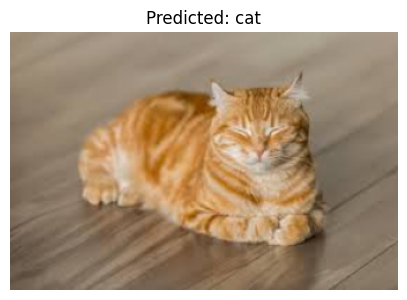

- Custom image predicted as 'cat'
✓ Custom image prediction completed!


In [9]:
print("\nSTEP 7: Predicting a custom image from current directory...")
from PIL import Image
import os

# Function to load and predict a local image
def predict_custom_image(filename):
    print(f"- Checking for image '{filename}' in current directory...")
    try:
        # Verify the file exists
        if not os.path.exists(filename):
            raise FileNotFoundError(f"Image file '{filename}' not found in current directory")
        print(f"- Image '{filename}' found!")
        
        # Load and preprocess the image
        print("- Loading and preprocessing image...")
        image = Image.open(filename).convert('RGB')  # Ensure RGB format
        image = transform(image)  # Apply CIFAR-10 transforms
        print(f"- Preprocessed image shape: {image.shape}")
        
        # Predict with the model
        print("- Making prediction...")
        with torch.no_grad():
            output = loaded_model(image.unsqueeze(0))  # Add batch dimension
            print(f"- Model output shape: {output.shape}")
            print(f"- Raw output: {output}")
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()
            print(f"- Predicted class index: {predicted_class}")
        
        # Verify prediction is valid
        if not 0 <= predicted_class < len(class_names):
            raise ValueError(f"Predicted class {predicted_class} out of range (0-{len(class_names)-1})")
        
        # Display the image and prediction
        plt.figure(figsize=(5, 5))
        img_to_show = image.permute(1, 2, 0) * 0.5 + 0.5  # Denormalize
        plt.imshow(img_to_show)
        plt.title(f"Predicted: {class_names[predicted_class]}")
        plt.axis('off')
        plt.show()
        print(f"- Custom image predicted as '{class_names[predicted_class]}'")
        
    except Exception as e:
        print(f"ERROR processing custom image: {str(e)}")
        raise

# Example: Predict an image named 'my_dog.jpg'
filename = "data/test/cat1.jpeg"  # Replace with your image's name
predict_custom_image(filename)

print("✓ Custom image prediction completed!")

## Full Code

STEP 1: Importing and verifying libraries...
- PyTorch version: 2.5.1+cu124
- Torchvision version: 0.20.1+cu124
- PyTorch Lightning version: 2.5.1
- CUDA available: True
✓ Libraries imported and verified!

STEP 2: Defining model architecture...
- Loading ResNet18 backbone...
- Removing final layers...
- Backbone output shape: torch.Size([1, 512, 7, 7])
- Defining custom head...
- Defining complete model...
✓ Model architecture defined!

STEP 3: Preparing CIFAR-10 dataset...
- Defining transformations...
- Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\sarak\02_new_code\05_tut_proj\03_pytorch\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will 

- Training samples: 50000
- Test samples: 10000
- Creating data loaders...
- Class names: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
- Number of classes: 10
✓ Dataset preparation completed!

STEP 4: Setting up training system...
✓ Training system setup completed!

STEP 5: Starting training...
- Number of classes set to: 10
- CustomHead initialized with 512 input features and 10 output classes
- CustomModel initialized with 10 classes
- Training system initialized with 10 classes
- Model summary:
CIFAR10TrainingSystem(
  (model): CustomModel(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_si


  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | CustomModel      | 11.2 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode
C:\Users\sarak\02_new_code\05_tut_proj\03_pytorch\pytorch_env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


- Training finished successfully!
✓ Training completed!

STEP 6: Saving and testing model...
- Saving model weights...
✓ Model saved to 'cifar10_model.pth'
- Loading model for inference...
- CustomHead initialized with 512 input features and 10 output classes
- CustomModel initialized with 10 classes
✓ Model loaded successfully!

Testing on sample images...
- Testing indices: [0, 1000, 5000]
- Processing test image 0...
- Image shape: torch.Size([3, 224, 224]), Label: 3
- Model output shape: torch.Size([1, 10])
- Raw output: tensor([[ -3.8035,  -7.2910,  -1.8160,   6.5184,  -7.8245,   0.6855,  -4.0944,
          -8.3575,  -9.4045, -10.7708]])
- Predicted class index: 3


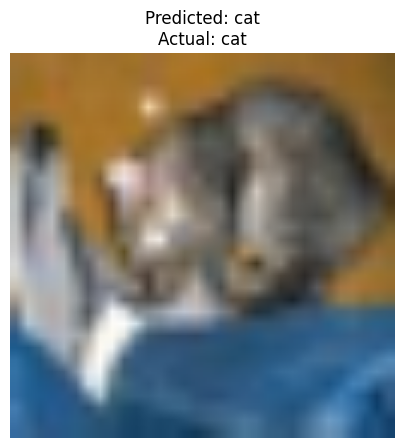

- Image 0: Predicted 'cat' (Actual: 'cat')
- Processing test image 1000...
- Image shape: torch.Size([3, 224, 224]), Label: 5
- Model output shape: torch.Size([1, 10])
- Raw output: tensor([[-9.3555, -9.1328, -4.6341,  1.3674, -5.8758,  5.9026,  1.3959, -5.9802,
         -8.2829, -7.8840]])
- Predicted class index: 5


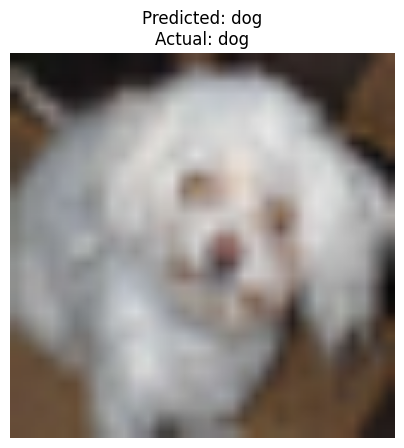

- Image 1000: Predicted 'dog' (Actual: 'dog')
- Processing test image 5000...
- Image shape: torch.Size([3, 224, 224]), Label: 7
- Model output shape: torch.Size([1, 10])
- Raw output: tensor([[-10.7836,  -6.4267, -13.4213,  -7.2330,  -6.5405,  -2.7434, -11.3278,
          15.4603, -14.1734,  -9.0385]])
- Predicted class index: 7


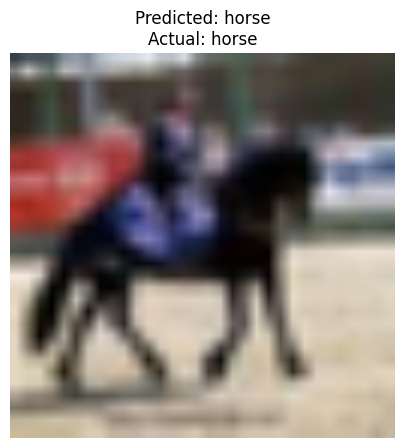

- Image 5000: Predicted 'horse' (Actual: 'horse')
✓ Testing completed!


In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Import and verify libraries
print("STEP 1: Importing and verifying libraries...")
print(f"- PyTorch version: {torch.__version__}")
print(f"- Torchvision version: {torchvision.__version__}")
print(f"- PyTorch Lightning version: {pl.__version__}")
print(f"- CUDA available: {torch.cuda.is_available()}")
print("✓ Libraries imported and verified!")

# Step 2: Define model architecture
print("\nSTEP 2: Defining model architecture...")
print("- Loading ResNet18 backbone...")
try:
    backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    print("- Removing final layers...")
    backbone = nn.Sequential(*list(backbone.children())[:-2])
    test_input = torch.randn(1, 3, 224, 224)
    test_output = backbone(test_input)
    print(f"- Backbone output shape: {test_output.shape}")
except Exception as e:
    print(f"ERROR in backbone setup: {str(e)}")
    raise

print("- Defining custom head...")
class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features, num_classes)
        print(f"- CustomHead initialized with {in_features} input features and {num_classes} output classes")
    
    def forward(self, x):
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

print("- Defining complete model...")
class CustomModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.head = CustomHead(512, num_classes)
        print(f"- CustomModel initialized with {num_classes} classes")
        
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

print("✓ Model architecture defined!")

# Step 3: Prepare dataset
print("\nSTEP 3: Preparing CIFAR-10 dataset...")
print("- Defining transformations...")
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("- Loading CIFAR-10 dataset...")
try:
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    print(f"- Training samples: {len(train_dataset)}")
    print(f"- Test samples: {len(test_dataset)}")
except Exception as e:
    print(f"ERROR in dataset loading: {str(e)}")
    raise

print("- Creating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"- Class names: {class_names}")
print(f"- Number of classes: {len(class_names)}")
print("✓ Dataset preparation completed!")

# Step 4: Define training system
print("\nSTEP 4: Setting up training system...")
class CIFAR10TrainingSystem(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = CustomModel(backbone, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        print(f"- Training system initialized with {num_classes} classes")
        
    def forward(self, x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        self.log('train_loss', loss)
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

print("✓ Training system setup completed!")

# Step 5: Training
print("\nSTEP 5: Starting training...")
num_classes = 10
print(f"- Number of classes set to: {num_classes}")
try:
    model_system = CIFAR10TrainingSystem(num_classes)
    print("- Model summary:")
    print(model_system)
    
    print("- Starting training for 5 epochs...")
    trainer = pl.Trainer(max_epochs=5, accelerator='auto', devices=1)
    trainer.fit(model_system, train_loader)
    print("- Training finished successfully!")
except Exception as e:
    print(f"ERROR during training: {str(e)}")
    raise

print("✓ Training completed!")

# Step 6: Save and test model
print("\nSTEP 6: Saving and testing model...")
print("- Saving model weights...")
try:
    torch.save(model_system.model.state_dict(), 'cifar10_model.pth')
    print("✓ Model saved to 'cifar10_model.pth'")
except Exception as e:
    print(f"ERROR saving model: {str(e)}")
    raise

print("- Loading model for inference...")
try:
    loaded_model = CustomModel(backbone, num_classes)
    loaded_model.load_state_dict(torch.load('cifar10_model.pth', weights_only=True))
    loaded_model.eval()
    print("✓ Model loaded successfully!")
except Exception as e:
    print(f"ERROR loading model: {str(e)}")
    raise

print("\nTesting on sample images...")
def predict_and_show(idx):
    print(f"- Processing test image {idx}...")
    try:
        image, label = test_dataset[idx]
        print(f"- Image shape: {image.shape}, Label: {label}")
        
        with torch.no_grad():
            output = loaded_model(image.unsqueeze(0))
            print(f"- Model output shape: {output.shape}")
            print(f"- Raw output: {output}")
            _, predicted = torch.max(output, 1)
            predicted_class = predicted.item()
            print(f"- Predicted class index: {predicted_class}")
        
        # Verify indices are valid
        if not 0 <= predicted_class < len(class_names):
            raise ValueError(f"Predicted class {predicted_class} out of range (0-{len(class_names)-1})")
        if not 0 <= label < len(class_names):
            raise ValueError(f"Label {label} out of range (0-{len(class_names)-1})")
        
        # Display results
        plt.figure(figsize=(5, 5))
        img_to_show = image.permute(1, 2, 0) * 0.5 + 0.5
        plt.imshow(img_to_show)
        plt.title(f"Predicted: {class_names[predicted_class]}\nActual: {class_names[label]}")
        plt.axis('off')
        plt.show()
        print(f"- Image {idx}: Predicted '{class_names[predicted_class]}' (Actual: '{class_names[label]}')")
        
    except Exception as e:
        print(f"ERROR in predict_and_show for image {idx}: {str(e)}")
        raise

# Test on sample images
valid_indices = [0, min(1000, len(test_dataset)-1), min(5000, len(test_dataset)-1)]
print(f"- Testing indices: {valid_indices}")
for idx in valid_indices:
    predict_and_show(idx)

print("✓ Testing completed!")